In [2]:
from commonfunctions import *
from scipy.signal import find_peaks, find_peaks_cwt
import math

# Show the matlpotlib figures inside the notebook
%matplotlib inline

In [4]:
def deskew(img):
    edged = cv2.Canny(img, 50, 200, None, 3)
    linesP = cv2.HoughLinesP(edged, 1, np.pi / 180, min(img.shape[0], img.shape[1]) // 4, None, 0, 20)
    # if linesP is not None:
    #     for i in range(0, len(linesP)):
    #         l = linesP[i][0]
    #         cv2.line(img, (l[0], l[1]), (l[2], l[3]), (125,125,125), 3, cv2.LINE_AA)
    slopes = [(y2 - y1)/(x2 - x1) if (x2-x1) else math.inf for x1, y1, x2, y2 in linesP[:,0,:]]
    deg_angles = [round(np.degrees(np.arctan(x)), 2) for x in slopes]

    histo = np.histogram(deg_angles, bins=180)
    bar(histo[1][:180].astype(np.uint8), histo[0][:180], width=0.8, align='center')
    # most frequent slope of all lines
    rotation_number = histo[1][np.argmax(histo[0])]
    print(rotation_number)
    rotated = rotate(img, rotation_number, resize=True)
    if rotated.dtype != "uint8":
        return (rotated * 255).astype("uint8")
    return rotated

In [6]:
def horz_proj(img, file):
    edged = cv2.Canny(img, 50, 200, None, 3)
    show_images([edged])
    edged[edged == 0] = 1
    edged[edged == 1] = 0
    proj = np.sum(edged,1)
    m = np.max(proj)
    w = 500
    # mn = np.min(proj)
    # if mn == 0: mn = 1
    # proj[proj <= mn * 50] = 0
    result = np.ones((proj.shape[0],500), dtype="uint8")
    result = result * 255
    # Draw a line for each row
    result = cv2.cvtColor(result,cv2.COLOR_GRAY2RGB)
    for row in range(img.shape[0]):
        if proj[row] != 0:
            cv2.line(result, (0,row), (int(proj[row]*w/m),row), (0,0,0), 1)
    show_images([result])
    cv2.imwrite("./test/{}".format(file), result)
    # Save result


In [115]:
def binraization(img,n=8,t=15):

    outputimg = np.zeros(img.shape)
    intimg = np.zeros(img.shape)
    h = img.shape[1]
    w = img.shape[0]
    s= min(w,h)//n
    count = s**2
    img = np.pad(img,s,"constant")
    intimg = np.cumsum(img ,axis =1)
    intimg = np.cumsum(intimg ,axis =0)
    a = np.roll(intimg,-s//2,axis =0)
    a = np.roll(a,-s//2,axis =1)
    a[:,-s//2:]=a[-s//2-1,-s//2-1]
    a[-s//2:,:]=a[-s//2-1,-s//2-1]
    b = np.roll(intimg,s//2+1,axis =0)
    b = np.roll(b,-s//2,axis =1)
    b[0:s//2+1,:]=0
    b[:,-s//2:]=0
    
    c = np.roll(intimg,s//2+1,axis =1)
    c = np.roll(c,-s//2,axis =0)
    c[:,0:s//2+1]=0
    c[-s//2:,:]=0
    
    d = np.roll(intimg,s//2+1,axis =0)
    d = np.roll(d,s//2+1,axis =1)
    d[0:s//2+1,:]=0
    d[:,0:s//2+1]=0

    sum = (a-b-c+d)*(100-t)/100
    outputimg = np.where(img>sum/count, 1, 0)
    return outputimg[s:-s,s:-s]

def segement_hand_written(img):
    h , w = img.shape 
    window , width = get_dimensions(w,h)
    fimg = median(img)
    glares = (fimg > 195)
    bimg = binraization(fimg,window,7)
    output = (bimg ) - (glares)
    output = median(output)
    output = binary_dilation(1-output)
    vse = np.array([[0,1,0],
                    [0,1,0],
                    [0,1,0]      ])

    hse = np.array([[0,0,0],
                    [1,1,1],
                    [0,0,0]
    ])
    output = binary_dilation(output , vse)
    output = binary_dilation(output , hse)
    output = 1 - output
    return output #the reuslt is binary image
def getLines(img, staffHeight, spaceHeight):
    rows_sum = np.sum(1 - img, axis=1)
    m = np.max(rows_sum)
    w = 500
    result = np.ones((rows_sum.shape[0],500), dtype="uint8")
    result = result * 255
    for row in range(img.shape[0]):
        if rows_sum[row] != 0:
            cv2.line(result, (0,row), (int(rows_sum[row]*w/m),row), (0,0,0), 1)
    cv2.imshow("a", cv2.resize(result, (960, 540)))
    print(np.sort(rows_sum)[rows_sum.shape[0] // 2])
    print(img.shape[1] * 0.5)
    lines,_  = find_peaks(rows_sum, height = np.sort(rows_sum)[-1] * 0.5, distance=spaceHeight+staffHeight//2)
    return lines

def segmentImage(lines, spaceHeight, height):
    detected_lines = np.zeros((height,))
    detected_lines[lines] = 1

    starts = np.array((detected_lines[:-1] == 1) & (detected_lines[1:] == 0))
    starts_ix = np.where(starts)[0] + 1
    ends = np.array((detected_lines[:-1] == 0) & (detected_lines[1:] == 1))
    ends_ix = np.where(ends)[0]

    starts_ix = starts_ix[:-1]
    ends_ix = ends_ix[1:]

    halfs = [0]

    for i in range(len(starts_ix)):
        diff = ends_ix[i] - starts_ix[i]
        if diff > 5 * spaceHeight:
            halfs.append((ends_ix[i] + starts_ix[i])//2)

    halfs.append(height-1)

    return halfs

../inputs/test-set-camera-captured/test-cases
89.00477777777776


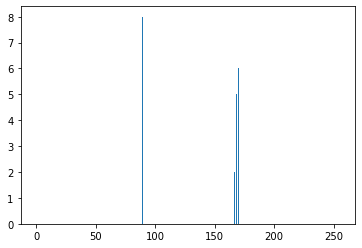

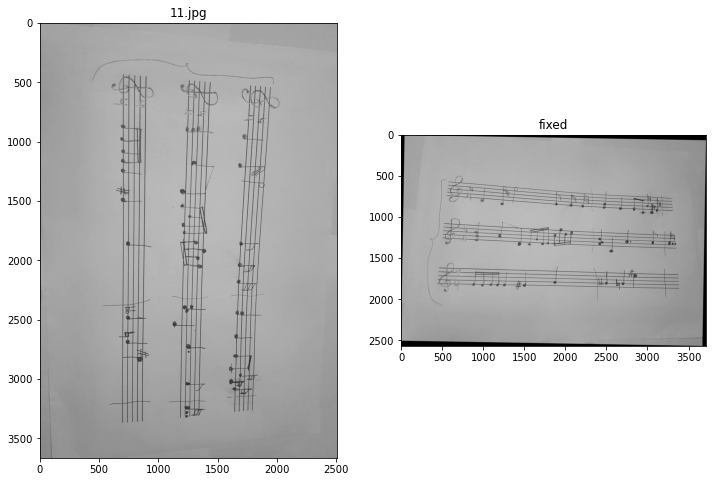

In [112]:
# images, files = load_images_from_folder("../inputs/test-set-scanned/test-cases")
images, files = load_images_from_folder("../inputs/test-set-camera-captured/test-cases")
images = [images[0]]
files = [files[0]]
outpath = "../outputs/"
for image, file in zip(images, files):
    h, w = image.shape
    # _, wid = get_dimensions(w, h)
    # if wid != 0:
    #     image = resize(image, width = wid)
    fixed = deskew(image)
    # horz_proj(fixed, file)
    show_images([image, fixed], [file, "fixed"])
    cv2.imwrite(outpath + file, fixed)

In [113]:
h , w = fixed.shape 
window , width = get_dimensions(w,h)
hist = histogram(fixed,nbins=256,source_range='dtype')
hist_acc =np.cumsum(hist[0])
tratio = ((hist_acc[255]-hist_acc[206] + hist_acc[49]-hist_acc[0]) / hist_acc[-1])*100
tmp = []
if ( tratio < 4):
    tmp = segement_hand_written(fixed)
elif ( 75 > tratio > 4):
    tmp = binraization(fixed,window,35)
else: 
    tmp = (fixed > 150).astype("uint8")

thickness, distance = get_lengthes(tmp)
print(thickness, distance)

10 32


In [117]:

lines = getLines(tmp, thickness, distance)
# halfs = segmentImage(lines, distance, fixed.shape[1])
halfs = lines
im = fixed.copy()
for half in halfs:
    cv2.line(im, (0, half), (im.shape[1], half), (125,125,125), 3, cv2.LINE_AA)
print(halfs)
cv2.imshow("t", cv2.resize(im, (960, 540)))
cv2.waitKey(0)     
cv2.destroyAllWindows()

100
1854.0
[]


In [96]:
img = cv2.imread("../outputs/19.jpg")
edged = cv2.Canny(img, 50, 200, None, 3)
cv2.imwrite("a.jpg", edged)


True